## Fast Fourier Transform

The Discrete Fourier transform is slow. If sample points $y_n$ are assumed to be real, we need up to $(N/2)+1$ coefficients, that are each sum of $N$ terms. Thus, constructing the entire Fourier transform boils down to $((N/2)+1)N\sim\mathcal{O}(N^2/2)$ operations.  

The fast fourier transform is a simple trick introduced by Carl Friedrich Gauss in 1805. A Fourier coefficient
$$
c_k = \sum_{n=0}^{N-1} y_n \exp\left(-i\frac{2\pi kn}{N}\right)
$$
can be written as sum of even and odd terms, where the even sum is,
$$ E_k = \sum_{r=0}^{(N/2)-1} y_{2r} \exp\left(-i\frac{2\pi k(2r)}{N}\right) = \sum_{r=0}^{(N/2)-1} y_{2r} \exp\left(-i\frac{2\pi k r}{(N/2)}\right) $$
which is another Fourier sum, with half the number of sample points, and the odd sum is,
$$ \sum_{r=0}^{(N/2)-1} y_{2r+1} \exp\left(-i\frac{2\pi k(2r+1)}{N}\right) = e^{-i2\pi k/N}\sum_{r=0}^{(N/2)-1} y_{2r+1} \exp\left(-i\frac{2\pi k r}{(N/2)}\right) = e^{-i2\pi k/N} O_k$$
which is another Fourier sum, with half the number of sample points, multiplied by a *twiddle factor*. This process of halving the sum is repeated until we end up with sample points $N=1$, that is, the sample point is its own Fourier coefficient. Each coefficients are then collected in pairs, 4s, 8s and so on, until we obtain the entire Fourier transform.

The above step, generalized to the mth step gives us
$$ E_k^{(m,j)} = E_k^{(m+1,j)} + e^{-i2\pi2^mk/N}E_k^{(m+1,j+2^m)} $$
starting at the last level, $m=\log_2N$, and repeatedly calculating $E_k^{(m,j)}$ for all $j$ and $k$, until we get down to $m=0$, which gives the full Fourier transform (see section 7.4.1 for the full derivation).

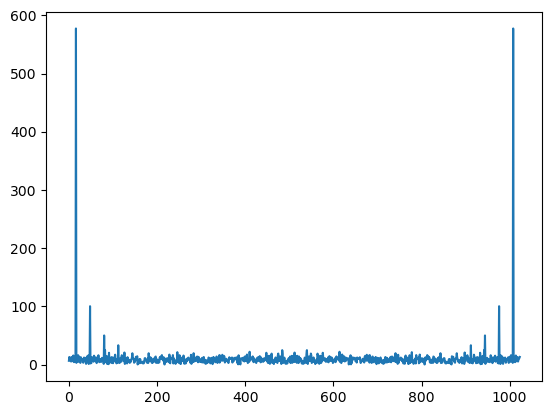

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class E_wrap:
    def __init__(self, N):
        self.array = np.zeros((1+int(np.log2(N)),N),complex)
        self.N = N

    def __getitem__(self, indices):
        m, j, k = indices
        k %= self.N/2**m
        k = int(k)
        return self.array[m,j+2**m*k]

    def __setitem__(self, indices, value):
        m, j, k = indices
        k %= self.N/2**m
        k = int(k)
        self.array[m, j+2**m*k] = value

def fft(y):
    N = len(y)
    E = E_wrap(N)
    E.array[-1,:] = y

    for m in range(int(np.log2(N))-1,-1,-1):
        for j in range(2**m):
            for k in range(N//2**m):
                E[m,j,k] = E[m+1,j,k] + np.exp(-2j*np.pi*k/(N/2**m))*E[m+1,j+2**m,k]
    return E.array[0,:]

y = np.loadtxt('pitch.txt')
c = fft(y)
plt.plot(abs(c))

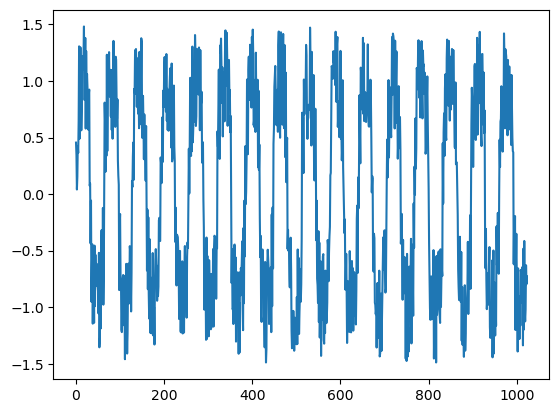

In [ ]:
plt.plot(np.fft.ifft(c))

## Spectral Methods



<ipython-input-7-3399250beef7>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  y2[1:N] = y[1:]
<ipython-input-7-3399250beef7>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  y2[:N:-1] = -y[1:]


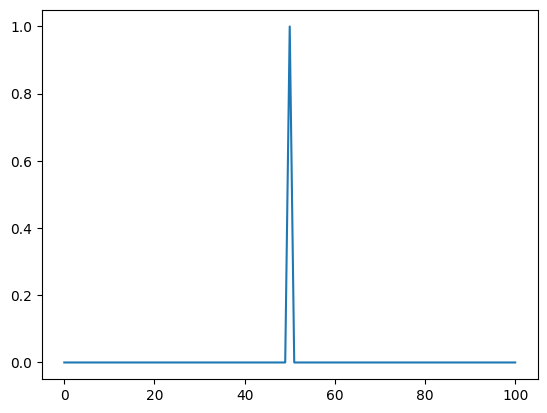

In [7]:
import numpy as np
import matplotlib.pyplot as plt

xmin  = 0                                    # --- Left boundary of the simulation domain
xmax  = 2. * np.pi                           # --- Right boundary of the simulation domain
N     = 100                                  # --- Number of space mesh points
v     = 0.5                                  # --- Wave speed
L     = xmax - xmin
omega = np.pi*v/L

a = L/N

def complex_arg(trans):
	return trans(real(y)) + 1j*trans(imag(y))

######################################################################
# 1D DST Type-I
######################################################################
def dst(y):
    N = len(y)
    y2 = np.empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -np.imag(np.fft.rfft(y2))[:N]
    a[0] = 0.0

    return a


######################################################################
# 1D inverse DST Type-I
######################################################################
def idst(a):
    N = len(a)
    c = np.empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = np.fft.irfft(c)[:N]
    y[0] = 0.0

    return y

ksi = np.zeros(N+1,complex)

def ksi0(x):
	x0 = L/2
	sigma = 1e-10
	k = 5e10
	return np.exp(-(x-x0)**2/2/sigma**2)*np.exp(1j*k*x)

x = np.linspace(0,L,N+1)
ksi[:] = ksi0(x)
ksi[[0,N]]=0

b0 = dst(ksi)

t = 1e-18
b_ = b0*np.exp(1j*omega*np.arange(N+1)*t)

ksi_ = idst(b_)
plt.plot(ksi_)
plt.show()